In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
import torch
import pickle
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
from gumbel import gumbel_softmax_new
from toolz.curried import pipe, curry, compose
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

In [8]:
#sample.py
from torchvision import transforms 
from build_vocab import Vocabulary
#train.py
from data_loader import get_loader

In [9]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [10]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)

        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids 


class Generator(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(Generator, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, states=None, temp=1.0, hard=False):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            outputs = gumbel_softmax_new(outputs, temp, hard, device=device)
            _, predicted = outputs.max(1)                        # predicted: (batch_size) #greedy heuristic
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)

        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids 
    
    
class SentenceEmbedder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(SentenceEmbedder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, captions):
        embeddings = self.embed(captions)
        embeddings, _ = self.lstm(embeddings)
        return embeddings

    
class ImageEmbedder(nn.Module):
    def __init__(self, embed_size, hidden_size):
        """Set the hyper-parameters and build the layers."""
        super(ImageEmbedder, self).__init__()
        self.linear = nn.Linear(embed_size, hidden_size)
        
    def forward(self, features):
        embeddings = self.linear(features)
        return embeddings

In [16]:
class Args():
    model_path = 'full_models_nb'
    crop_size = 224
    vocab_path = 'data/vocab.pkl'
    image_dir = 'data/resized2014'
    caption_path = 'data/annotations/captions_train2014.json'
    log_step = 10
    save_step = 1000
    embed_size = 256
    hidden_size = 512
    num_layers = 1
    num_epochs = 1
    batch_size = 1
    num_workers = 4
    learning_rate = 0.001
    cuda = True
args = Args()

if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)
    
device = torch.device("cuda:1")

transform = transforms.Compose([ 
    transforms.RandomCrop(args.crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


with open(args.vocab_path, 'rb') as f:
    vocab = pickle.load(f)
print("Size of Vocabulary: %d" % len(vocab))

data_loader = get_loader(args.image_dir, args.caption_path, vocab, 
                         transform, args.batch_size,
                         shuffle=True, num_workers=args.num_workers)

Size of Vocabulary: 9956
loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


In [17]:
%%bash
nvidia-smi

Tue Apr 30 05:29:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:02:00.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |     10MiB / 16280MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   28C    P0    31W / 250W |    885MiB / 16280MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   2  T

In [18]:
%%time
encoder = EncoderCNN(args.embed_size).to(device).eval()
decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)
generator = Generator(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)
sent_embedder = SentenceEmbedder(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)
img_embedder = ImageEmbedder(args.embed_size, args.hidden_size).to(device)


encoder_path = "models/encoder-2-1000.ckpt"
decoder_path = "models/decoder-2-1000.ckpt"

encoder.load_state_dict(torch.load(encoder_path, map_location=torch.device("cpu")))
decoder.load_state_dict(torch.load(decoder_path, map_location=torch.device("cpu")))
generator.load_state_dict(torch.load(decoder_path, map_location=torch.device("cpu")))
sent_embedder.load_state_dict(torch.load(decoder_path, map_location=torch.device("cpu")))

CPU times: user 1.56 s, sys: 588 ms, total: 2.15 s
Wall time: 2.83 s


In [19]:
# file_path = "png/cat_kiss.jpeg"
file_path = "png/kids-beach-playing-600jt082213.jpg"
file_path = "png/david.jpeg"
file_path = "png/berkay.jpeg"
file_path = "png/batter.png"
file_path = "png/girl_on_rock.png"
image = load_image(file_path, transform)
if image.shape[2] > 3:
    image = image[:,:3]
images = image.clone()
print("input single image: ", images.shape)


images_set = []
for i in range(5):
    noise = (torch.rand_like(images) - 0.5) * 0.001
    if i > 0:
        images_set.append(images+noise)
    else:
        images_set.append(images)
        
images_set = torch.cat(images_set, dim=0).to(device)
print("output many images", images_set.shape)
features = encoder(images_set)


temp = .8
hard = False
sampled_ids = generator(features, temp=temp, hard=hard)


for idx in range(5):
    sampled_caption = []
    for word_id in sampled_ids[idx]:
        word = vocab.idx2word[word_id.item()]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    print(sentence + "\n")

input single image:  torch.Size([1, 3, 224, 224])
output many images torch.Size([5, 3, 224, 224])
<start> a man on a surf board while riding a wave . <end>

<start> a person laying nest while standing on a skateboard in the air . <end>

<start> girl holding a lone brown and gray watches cover from the ocean <end>

<start> a boy is sticking out for a frisbee on the beach . <end>

<start> a man holding a surf board in between trees . <end>



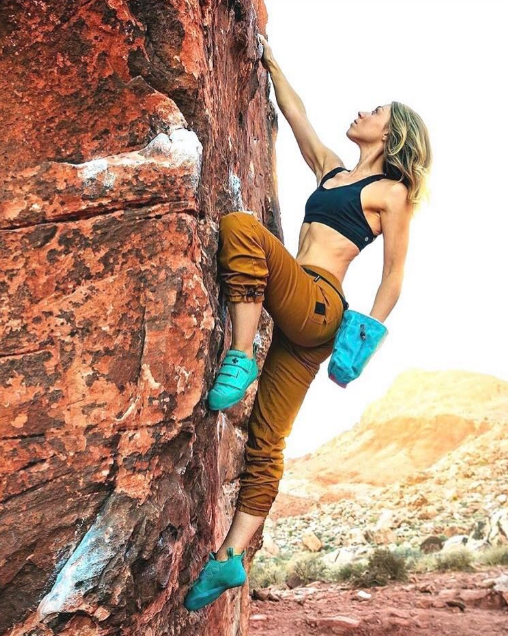

In [41]:
Image.open(file_path)

In [30]:
K = sent_embedder(sampled_ids)

In [28]:
def c_l(k1, k2):
    return torch.exp(-1 * torch.norm(k1 - k2,p=1))

In [40]:
ix = 0
for ix in range(20):
    print(c_l(K[0][ix], K[1][ix]))

tensor(1., device='cuda:1', grad_fn=<ExpBackward>)
tensor(1., device='cuda:1', grad_fn=<ExpBackward>)
tensor(5.7888e-39, device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda:1', grad_fn=<ExpBackward>)
tensor(0., device='cuda

In [20]:
class Discriminator(nn.Module):
    """
    A CaptioningRNN produces captions from image features using a recurrent
    neural network.

    The RNN receives input vectors of size D, has a vocab size of V, works on
    sequences of length T, has an RNN hidden dimension of H, uses word vectors
    of dimension W, and operates on minibatches of size N.

    Note that we don't use any regularization for the CaptioningRNN.
    """

    def __init__(self, 
                 word_to_idx, 
                 input_Dim=1, 
                 wordvec_Dim=128,
                 hidden_Dim=128,
                 num_layers=1,
                 N=128, 
                 O=128, 
                 image_input=512, 
                 set_size=10, 
                 use_cuda = False,
                 device = torch.device("cpu")):
        
        super(Discriminator, self).__init__()

        if torch.cuda.is_available() and use_cuda:
            self.use_cuda = True
            self.device = device
        else:
            self.device = torch.device("cpu")
            
        self.sentence_embedding= CaptioningModel(word_to_idx, 
                                                 input_dim=input_Dim, 
                                                 wordvec_dim=wordvec_Dim,
                                                 num_layers = num_layers,
                                                 hidden_dim=hidden_Dim, 
                                                 use_cuda = self.use_cuda, 
                                                 device = self.device)         
        
        vocab_size=len(word_to_idx)
        self.distance_layer_sentences = Distance_Sentences(vocab_size, N, O)
        self.distance_layer_images = Distance_Image(vocab_size, N, O, image_input)
        
        
        self.set_size = set_size
        self.projection = nn.Linear((self.set_size+1)*O, 2)
        
        
    def forward(self, captions, features):
        
        nsamples, _ = captions.shape
        
        ft = torch.zeros(nsamples,1).to(self.device)
        print("input to embedding", ft.shape)
        
        S = self.sentence_embedding.forward(ft, captions)
        print("Sentence Embedding Shape", S.shape)
        
        S = S[:,-1,:]
        print("Sentence Embedding Modified Shape", S.shape)
        
        S = S.view(S.shape[0] // self.set_size, self.set_size, -1)
        print(S.shape)
        
        o_sentence = self.distance_layer_sentences.forward(S)
        print("sentence distance", o_sentence.shape)

        o_image = self.distance_layer_images.forward(S,features)
        print("image distance", o_image.shape)
        
        o = torch.cat((o_image, o_sentence), 1).to(self.device)        
        print("distances concatenated", o.shape)
        
        D = nn.functional.log_softmax(self.projection(o),dim=1)
        print("logmax performed", D.shape)
        
        return D